SGD Applied to Linear Regression

In [26]:
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_diabetes
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from numpy import random
from sklearn.model_selection import train_test_split
import torch as torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

In [4]:
#data
#data loading and preprocessing
diabetes_data=pd.DataFrame(load_diabetes().data,columns=load_diabetes().feature_names)
Y=load_diabetes().target
X=load_diabetes().data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)

#Standardising
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

train_data=pd.DataFrame(x_train,columns=load_diabetes().feature_names)
train_data['Output']=y_train

In [42]:
train_losses = []
def CustomSGD(train_data, learning_rate, n_iter, k, divideby, init_w=None, init_b=0):
    model_w = torch.empty((train_data.shape[1]-1, 1)) # Add this line to access the global model_w variable
    model_b = torch.empty((1)) # Add this line to access the global model_b variable
    if init_w is None:
        w = np.zeros(shape=(1, train_data.shape[1]-1))
    else:
        w = init_w
    w_gradient = w
    if init_b is None:
        b = 0
    else:
        b_gradient = init_b
    cur_iter = 1
    while cur_iter <= n_iter: 
        temp = train_data.sample(k)
        y = np.array(temp['Output'])
        x = np.array(temp.drop('Output', axis=1))
        w_gradient = np.zeros(shape=(1, train_data.shape[1]-1))
        b_gradient = 0
        for i in range(k):
            prediction = np.dot(w, x[i]) + b
            w_gradient = w_gradient + (-2) * x[i] * (y[i] - prediction)
            b_gradient = b_gradient + (-2) * (y[i] - prediction)
        w = w - learning_rate * (w_gradient / k)
        b = b - learning_rate * (b_gradient / k)

        if cur_iter % 10 == 0:
            train_loss = 0
            for i in range(k):
                train_loss = train_loss + ((y[i] - np.dot(w, x[i]) - b) ** 2)
            print("Loss after", cur_iter, ":", train_loss, "w:", w, "b:", b)
            if cur_iter > 0.6 * n_iter:
                train_losses.append(train_loss)
                w1=torch.reshape(torch.tensor(w), (train_data.shape[1]-1, 1))
                model_w = torch.cat([model_w, w1],dim=1)  # Update model_w with new w
                model_b= torch.cat([model_b, torch.tensor(b)])
        cur_iter = cur_iter + 1
        learning_rate = learning_rate / divideby
    model_w = model_w[:,1:]  # Remove the initial column of zeros
    model_b = torch.transpose(model_b[1:].unsqueeze(1), 0, 1)  # Remove the initial column of zeros
    print(model_w.shape, model_b.shape)
    model_weights = torch.cat([model_b, model_w], dim=0)
    return w, b, model_weights

In [48]:
model_weights_list = torch.empty((11,1))  # Create an empty list to store model_w for each run

init_values = [np.zeros(shape=(1, train_data.shape[1]-1)), (np.ones(shape=(1, train_data.shape[1]-1)))]  # Add the desired init_w values

labels=[]
for idx, init_w in enumerate(init_values):
    w, b, model_weights = CustomSGD(train_data, learning_rate=0.01, n_iter=20000, k=10, divideby=1, init_w=init_w, init_b=None)
    model_weights_list = torch.cat([model_weights_list, model_weights], dim=1)  # Append the model_weights to the list for each run
    labels.append(np.ones(model_weights.shape[1])*idx)
model_weights_list = model_weights_list[:,1:]  # Remove the initial column of zeros
labels = np.concatenate(labels)
labels = tuple(labels)

Loss after 10 : [161794.72564667] w: [[ 8.2149223   6.2463409  10.11439613 14.46406122  3.3089593  -0.7131122
  -1.45651134  1.56386662 11.42694161  7.02330338]] b: [26.94082494]
Loss after 20 : [68770.07208182] w: [[10.32855043  0.56867805 14.21405994 15.48279899  0.53690611 -3.47827915
  -5.11220035  2.55617154 15.24117849  8.74034331]] b: [48.2485239]
Loss after 30 : [111470.66449932] w: [[ 9.53928295 -1.18074556 14.86282971 17.76061975  2.1747164  -1.43225591
  -5.86753456  3.20078088 15.47658767  9.88319403]] b: [65.4460139]
Loss after 40 : [39416.65419636] w: [[ 7.36234509 -1.00815417 16.69255937 18.35946124 -1.38987874 -4.61604428
  -6.19633552  1.9465768  13.6937753   9.73810265]] b: [80.33289738]
Loss after 50 : [52498.13455184] w: [[ 3.68327472 -5.24081726 20.01038556 15.03535761 -0.49823997 -3.69650963
  -6.60153075  3.57108918 14.06209289  7.44400943]] b: [92.11194854]
Loss after 60 : [52087.41214171] w: [[ 3.62995474 -6.22934508 23.71196918 17.24240401  2.0202128  -2.83709

Text(0.5, 1.0, 'PCA of LR weights after convergence')

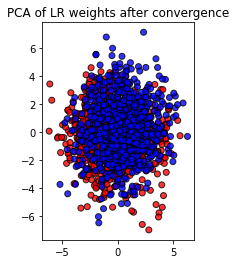

In [49]:
label_colour_mapping = {0: 'red', 1: 'blue'}
cvec = [label_colour_mapping[label] for label in labels]

from sklearn.decomposition import PCA
model_weights_list = torch.transpose(model_weights_list, 0, 1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(model_weights_list)

# Plot the data in the reduced-dimensional space after PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cvec, marker='o', edgecolors='k', alpha=0.8)
plt.title('PCA of LR weights after convergence')

Applied to 3 Layer MLP

In [ ]:
#cuda check
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [33]:
# Load the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False
)

In [34]:
# Define the network architecture
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # Define the layers of your network
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

In [38]:
#Create model_weights_list
model_weights_list = torch.empty((235146,1))
labels = [0]

# Create an instance of the network
network = MyNetwork()

# Define the loss function and optimiser
criterion = nn.CrossEntropyLoss()

iteration = 0
while iteration < 4:
    optimiser = optim.SGD(network.parameters(), lr=0.1, momentum=0, weight_decay=0.000)
    # Train the network
    num_epochs = 2
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Forward pass
            outputs = network(data)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Print the loss for every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
                if epoch>-1:
                    # Save the model weights
    #               torch.save(network.state_dict(), f'./model_weights/model_weights_{epoch+1}_{batch_idx+1}.pt')
                    # Print the model weights
                    current_model_weights = torch.cat([param.view(-1) for param in network.parameters()])
                    model_weights_list = torch.cat((model_weights_list, current_model_weights.unsqueeze(1)), 1)
                    print(model_weights_list)
                    labels.append(iteration)

    # Evaluate the performance of the network
    network.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in test_loader:
            outputs = network(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
    
    network = MyNetwork()
    iteration += 1

model_weights_list = model_weights_list[:,1:].detach()
labels = labels[1:]
model_weights_list = torch.transpose(model_weights_list, 0, 1)

Epoch [1/2], Step [100/938], Loss: 0.5097
tensor([[ 3.2773e-40, -2.8834e-02],
        [ 3.2846e-40, -7.8013e-03],
        [ 3.2893e-40, -3.2752e-02],
        ...,
        [ 8.5059e-43, -1.1035e-01],
        [ 0.0000e+00,  1.1520e-01],
        [ 0.0000e+00,  2.0197e-02]], grad_fn=<CatBackward0>)
Epoch [1/2], Step [200/938], Loss: 0.6071
tensor([[ 3.2773e-40, -2.8834e-02, -2.8981e-02],
        [ 3.2846e-40, -7.8013e-03, -7.9484e-03],
        [ 3.2893e-40, -3.2752e-02, -3.2900e-02],
        ...,
        [ 8.5059e-43, -1.1035e-01, -1.2676e-01],
        [ 0.0000e+00,  1.1520e-01,  1.2447e-01],
        [ 0.0000e+00,  2.0197e-02,  1.2839e-02]], grad_fn=<CatBackward0>)
Epoch [1/2], Step [300/938], Loss: 0.7936
tensor([[ 3.2773e-40, -2.8834e-02, -2.8981e-02, -2.9333e-02],
        [ 3.2846e-40, -7.8013e-03, -7.9484e-03, -8.3010e-03],
        [ 3.2893e-40, -3.2752e-02, -3.2900e-02, -3.3252e-02],
        ...,
        [ 8.5059e-43, -1.1035e-01, -1.2676e-01, -1.2151e-01],
        [ 0.0000e+00,  1.15

Text(0.5, 1.0, 'Logging all epochs every 100')

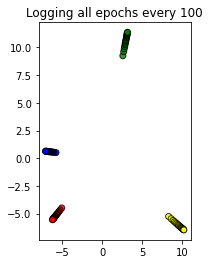

In [40]:
label_colour_mapping = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
cvec = [label_colour_mapping[label] for label in labels]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(model_weights_list)

# Plot the data in the reduced-dimensional space after PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cvec, marker='o', edgecolors='k', alpha=0.8)
plt.title('Logging all epochs every 100')